In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
agent1 = df_train[["agent1"]].drop_duplicates()["agent1"].tolist()
agent2 = df_train[["agent2"]].drop_duplicates()["agent2"].tolist()

all_agents = list(set(agent1) | set(agent2))
len(all_agents)


72

In [4]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [5]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

agent position feature
number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 368
Categorical Columns: 5


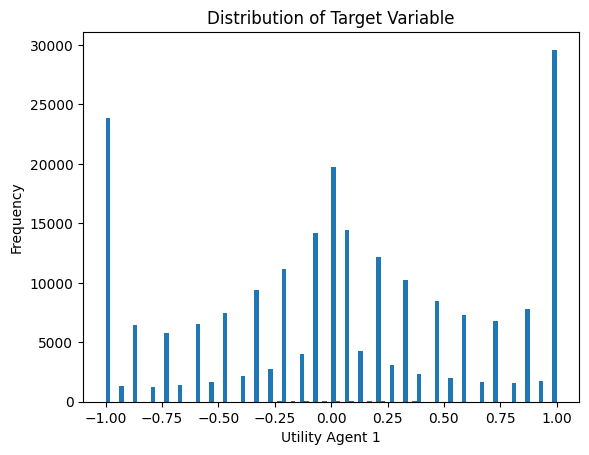

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


In [8]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6031503	test: 0.6051224	best: 0.6051224 (0)	total: 126ms	remaining: 6m 17s
50:	learn: 0.3955390	test: 0.4487064	best: 0.4487064 (50)	total: 3.8s	remaining: 3m 39s
100:	learn: 0.3581313	test: 0.4324247	best: 0.4324247 (100)	total: 7.61s	remaining: 3m 38s
150:	learn: 0.3375880	test: 0.4257468	best: 0.4257468 (150)	total: 11.2s	remaining: 3m 32s
200:	learn: 0.3231251	test: 0.4215327	best: 0.4215170 (199)	total: 14.9s	remaining: 3m 27s
250:	learn: 0.3120682	test: 0.4184567	best: 0.4184567 (250)	total: 18.5s	remaining: 3m 22s
300:	learn: 0.3036331	test: 0.4174338	best: 0.4173820 (296)	total: 22.2s	remaining: 3m 19s
350:	learn: 0.2965693	test: 0.4159763	best: 0.4159763 (350)	total: 25.9s	remaining: 3m 15s
400:	learn: 0.2905639	test: 0.4147970	best: 0.4147970 (400)	total: 29.5s	remaining: 3m 11s
450:	learn: 0.2848337	test: 0.4139148	best: 0.4139148 (450)	total: 33.2s	remaining: 3m 7s
500:	learn: 0.2796361	test: 0.4127393	best: 0.4127393 (500)	total: 37s	remaining: 3m 4s
550

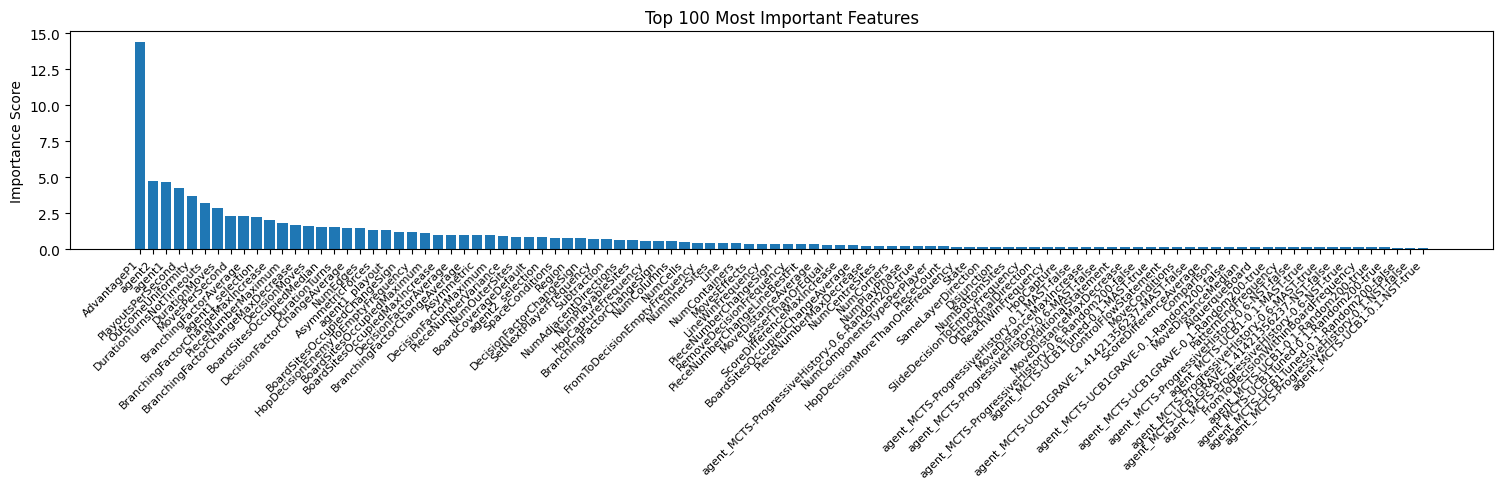

Fold 1 - RMSE: 0.4047069075852309
Fold 2
0:	learn: 0.5982384	test: 0.6161155	best: 0.6161155 (0)	total: 64.4ms	remaining: 3m 13s
50:	learn: 0.3866743	test: 0.4841534	best: 0.4841534 (50)	total: 3.5s	remaining: 3m 22s
100:	learn: 0.3521863	test: 0.4714673	best: 0.4713903 (99)	total: 7.11s	remaining: 3m 24s
150:	learn: 0.3328935	test: 0.4667446	best: 0.4667446 (150)	total: 10.6s	remaining: 3m 20s
200:	learn: 0.3201846	test: 0.4639612	best: 0.4639213 (194)	total: 14.3s	remaining: 3m 19s
250:	learn: 0.3099826	test: 0.4615926	best: 0.4615926 (250)	total: 17.9s	remaining: 3m 16s
300:	learn: 0.3018703	test: 0.4603569	best: 0.4603569 (300)	total: 21.6s	remaining: 3m 13s
350:	learn: 0.2948625	test: 0.4594924	best: 0.4594924 (350)	total: 25.3s	remaining: 3m 10s
400:	learn: 0.2885394	test: 0.4582307	best: 0.4582307 (400)	total: 29s	remaining: 3m 7s
450:	learn: 0.2829958	test: 0.4575306	best: 0.4575306 (450)	total: 32.7s	remaining: 3m 4s
500:	learn: 0.2781420	test: 0.4565702	best: 0.4565702 (500)	

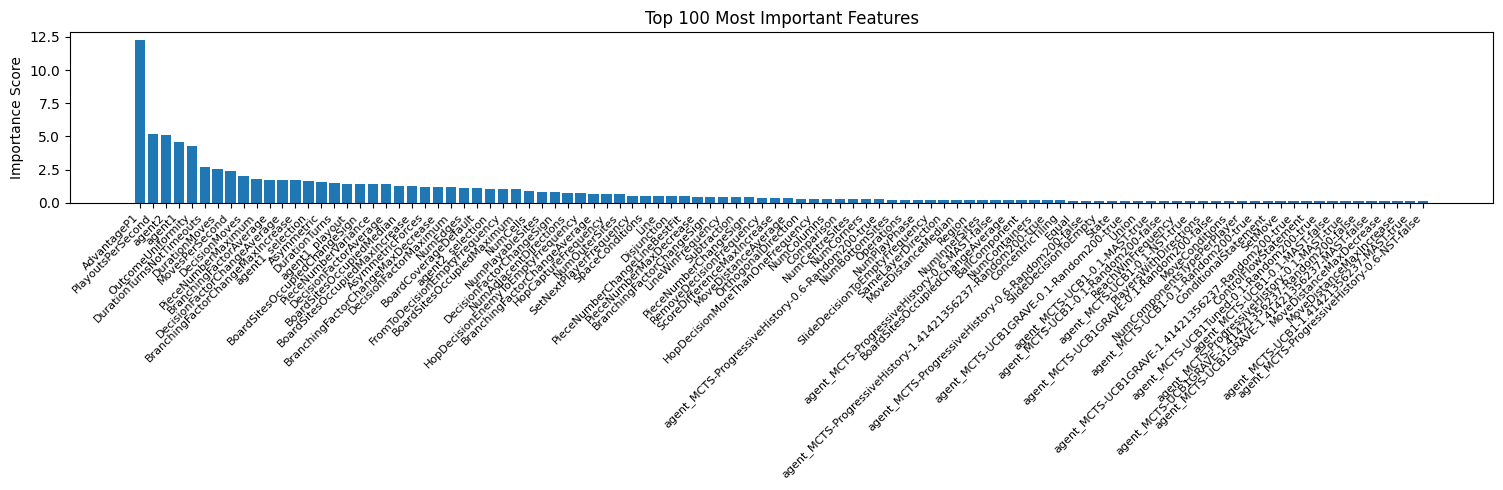

Fold 2 - RMSE: 0.44709937398864297
Fold 3
0:	learn: 0.6062662	test: 0.5856109	best: 0.5856109 (0)	total: 73.8ms	remaining: 3m 41s
50:	learn: 0.3935427	test: 0.4513280	best: 0.4513280 (50)	total: 3.93s	remaining: 3m 47s
100:	learn: 0.3570006	test: 0.4350941	best: 0.4350941 (100)	total: 8.14s	remaining: 3m 53s
150:	learn: 0.3374979	test: 0.4263474	best: 0.4263474 (150)	total: 12.3s	remaining: 3m 51s
200:	learn: 0.3231782	test: 0.4218285	best: 0.4217016 (197)	total: 16.4s	remaining: 3m 48s
250:	learn: 0.3123576	test: 0.4193268	best: 0.4193268 (250)	total: 20.5s	remaining: 3m 45s
300:	learn: 0.3033156	test: 0.4166723	best: 0.4166723 (300)	total: 24.8s	remaining: 3m 42s
350:	learn: 0.2952687	test: 0.4147719	best: 0.4147324 (349)	total: 28.9s	remaining: 3m 37s
400:	learn: 0.2886134	test: 0.4139073	best: 0.4139021 (398)	total: 33.1s	remaining: 3m 34s
450:	learn: 0.2829870	test: 0.4129414	best: 0.4129275 (448)	total: 37.4s	remaining: 3m 31s
500:	learn: 0.2780914	test: 0.4118542	best: 0.4118542

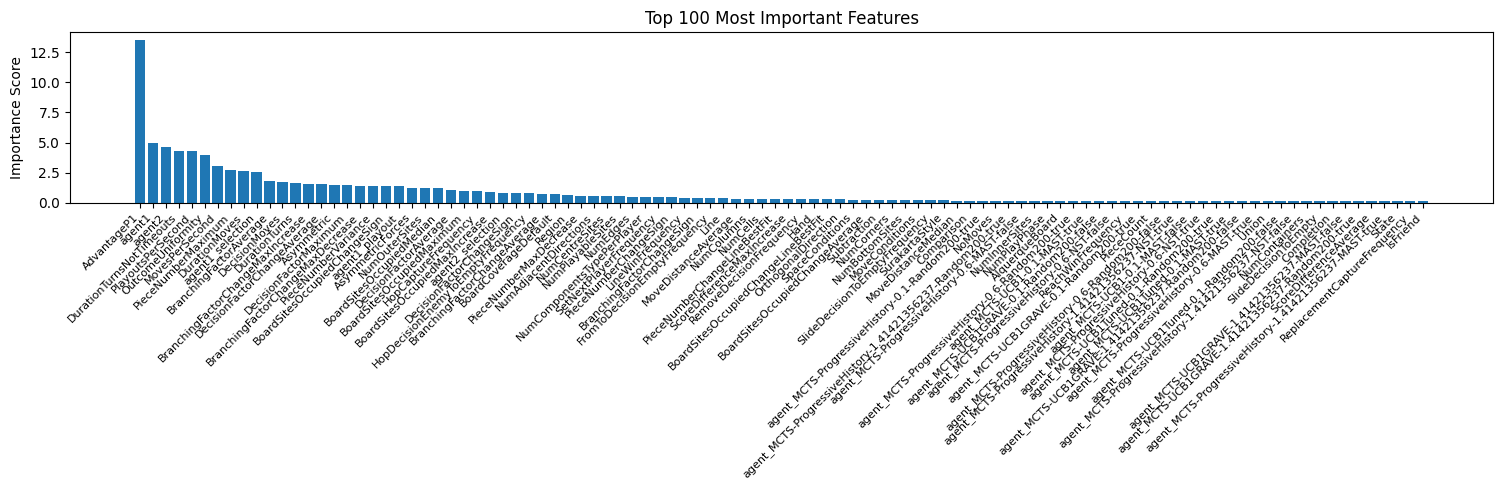

Fold 3 - RMSE: 0.40462555515518234
Fold 4
0:	learn: 0.5991837	test: 0.6171679	best: 0.6171679 (0)	total: 60ms	remaining: 2m 59s
50:	learn: 0.3908161	test: 0.4656782	best: 0.4656782 (50)	total: 3.95s	remaining: 3m 48s
100:	learn: 0.3571591	test: 0.4475628	best: 0.4475628 (100)	total: 8.16s	remaining: 3m 54s
150:	learn: 0.3375831	test: 0.4388188	best: 0.4388188 (150)	total: 12.4s	remaining: 3m 53s
200:	learn: 0.3240808	test: 0.4347038	best: 0.4347038 (200)	total: 16.6s	remaining: 3m 50s
250:	learn: 0.3132948	test: 0.4306571	best: 0.4306571 (250)	total: 20.7s	remaining: 3m 46s
300:	learn: 0.3048247	test: 0.4282353	best: 0.4282353 (300)	total: 25s	remaining: 3m 43s
350:	learn: 0.2977326	test: 0.4261287	best: 0.4261287 (350)	total: 29.2s	remaining: 3m 40s
400:	learn: 0.2913896	test: 0.4245708	best: 0.4244895 (397)	total: 33.5s	remaining: 3m 37s
450:	learn: 0.2857369	test: 0.4231295	best: 0.4231295 (450)	total: 37.8s	remaining: 3m 33s
500:	learn: 0.2803713	test: 0.4218889	best: 0.4218852 (49

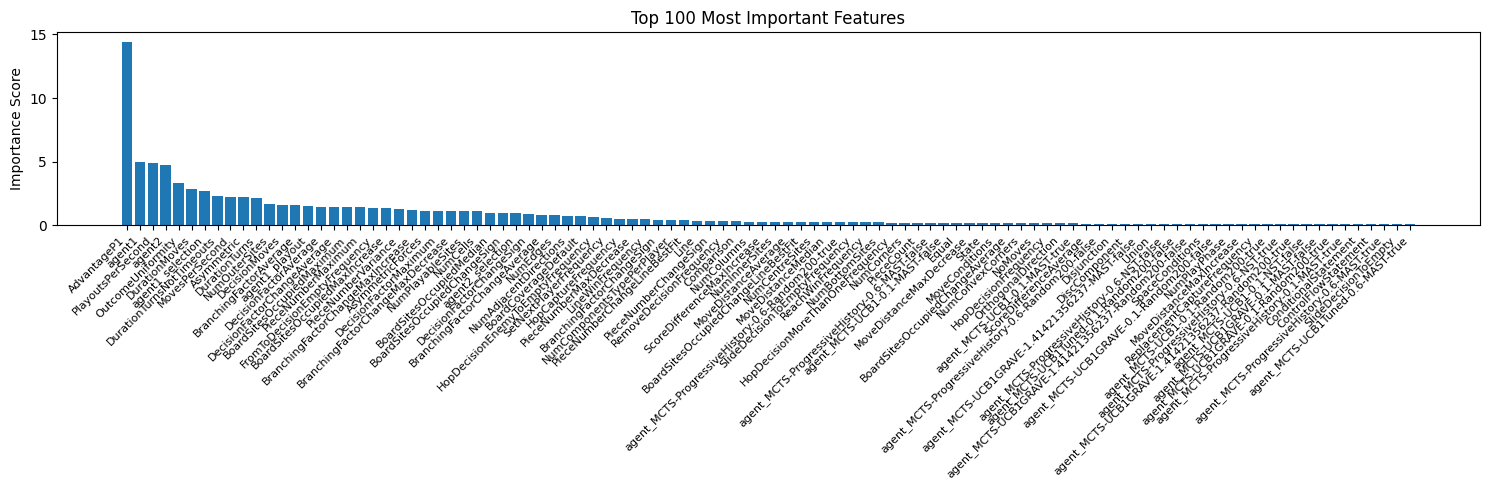

Fold 4 - RMSE: 0.4098553657602444
Fold 5
0:	learn: 0.6005189	test: 0.6131573	best: 0.6131573 (0)	total: 70.9ms	remaining: 3m 32s
50:	learn: 0.3951078	test: 0.4712765	best: 0.4712499 (49)	total: 4.29s	remaining: 4m 8s
100:	learn: 0.3590759	test: 0.4545469	best: 0.4545463 (98)	total: 8.8s	remaining: 4m 12s
150:	learn: 0.3380834	test: 0.4480508	best: 0.4479890 (149)	total: 13.2s	remaining: 4m 8s
200:	learn: 0.3247216	test: 0.4443982	best: 0.4443982 (200)	total: 17.5s	remaining: 4m 3s
250:	learn: 0.3145317	test: 0.4420876	best: 0.4420852 (249)	total: 21.9s	remaining: 3m 59s
300:	learn: 0.3058814	test: 0.4402839	best: 0.4402839 (300)	total: 26.5s	remaining: 3m 57s
350:	learn: 0.2984596	test: 0.4389796	best: 0.4389782 (347)	total: 30.9s	remaining: 3m 53s
400:	learn: 0.2922992	test: 0.4380752	best: 0.4380752 (400)	total: 35.5s	remaining: 3m 50s
450:	learn: 0.2862116	test: 0.4368807	best: 0.4368636 (442)	total: 40s	remaining: 3m 45s
500:	learn: 0.2808729	test: 0.4355974	best: 0.4355892 (499)	t

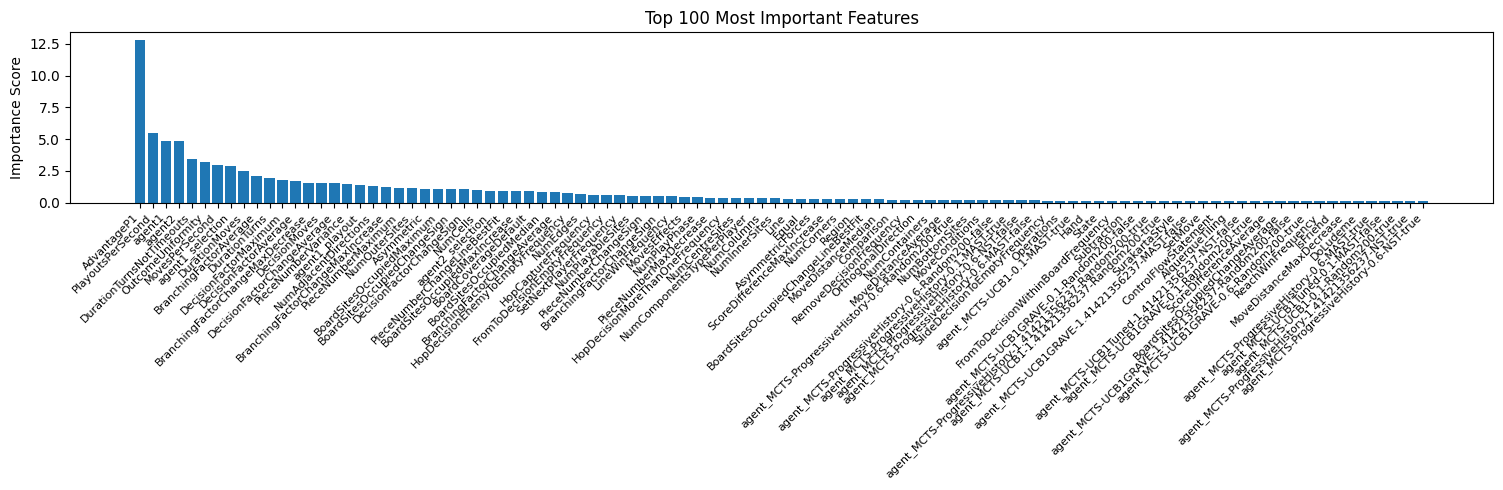

Fold 5 - RMSE: 0.4283372260020486
List of oof scores: [0.4047069075852309, 0.44709937398864297, 0.40462555515518234, 0.4098553657602444, 0.4283372260020486]
Average oof score: 0.4189248856982698


In [9]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        num_folds=5,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=2112, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols
        )
        val_pool = cb.Pool(
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

# Call the function
trained_models, oof, oof_scores = train_models(df_train, numerical_cols, categorical_cols)

# # save oof predictions
oof.to_csv(path_results / 'oof_catboost.csv', index=False)

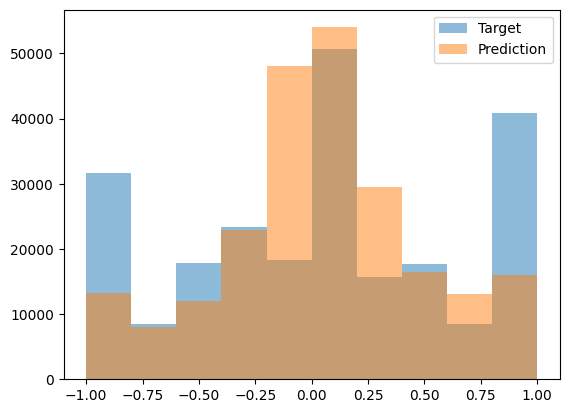

In [10]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [11]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [12]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [13]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

agent position feature


Id,utility_agent1
i64,f64
233234,0.121696
233235,-0.129359
233236,-0.089224


In [14]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

agent position feature


In [15]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
